In [134]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 13 00:16:15 2020

@author: hongjunyu
"""
import os
import pandas as pd
import numpy as np
import nltk
import string
import joblib
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
os.chdir('/Users/hongjunyu/desktop/spooky author identification')

In [135]:
#read the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
test_data['author'] = None

In [136]:
#get embedding matrix
embedding_matrix = {}
f = open('glove.6b.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coef = np.asarray(values[1:], dtype='float32')
    embedding_matrix[word] = coef
f.close()

In [137]:
#some useful functions
def text_cleaning(text):
    
    #remove stopwords
    text = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    #remove punctuations
    text = [element for element in text if element not in string.punctuation]
    #lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]
    #stemming
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    
    return text

def get_noun_number(text):
   
    noun_list = ['NN', 'NNP', 'NNPS', 'NNS']
    
    text1 = [i.lower() for i in word_tokenize(text) if i not in puncts]
    text2 = nltk.pos_tag(text1)
    
    n_noun = len([i for i in text2 if i[1] in noun_list])
    
    return n_noun

def get_adj_number(text):
    
    adj_list = ['JJ', 'JJR', 'JJS']
    
    text1 = [i.lower() for i in word_tokenize(text) if i not in puncts]
    text2 = nltk.pos_tag(text1)
    
    n_adj = len([i for i in text2 if i[1] in adj_list])
    
    return n_adj
    

def get_verb_number(text):

    verb_list = ['VB','VBD','VBG','VBN','VBP','VBZ']
    
    text1 = [i.lower() for i in word_tokenize(text) if i not in puncts]
    text2 = nltk.pos_tag(text1)
    
    n_verb = len([i for i in text2 if i[1] in verb_list])
    
    return n_verb

def convert_to_one_hot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)]
    
    return Y

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def sentence_to_avg(sentence, word_to_vec_map):
    
    # 取出句子中的每一个单词，并且转换成小写形式
    words = [i.lower() for i in word_tokenize(sentence) if i not in puncts]

    avg = np.zeros((200,))
    
    # 遍历每一个单词，并且转换成Glove向量，然后将每个向量累加起来
    for w in words:
        try:
            avg += word_to_vec_map[w]
        except Exception as r:
            avg += 0
            
    # 求出一个平均值向量
    avg = avg / len(words)
    
    return avg

In [138]:
#some instantiations
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
vectorizer = CountVectorizer()
stop_words = stopwords.words('english')
tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',analyzer='word',
                      ngram_range=(1,3), smooth_idf=1, sublinear_tf=1, stop_words='english')
standard_scaler = StandardScaler()
svd = TruncatedSVD(n_components=120)
puncts = string.punctuation


#encode the target
y = label_encoder.fit_transform(train_data['author'])
train_data['author'] = y

In [139]:
%%time
#generate features

#general features(before cleaning):
#number of words
train_data['n_words'] = train_data['text'].apply(lambda x:len([i for i in x.split()]))
#number of characters
train_data['n_chars'] = train_data['text'].apply(lambda x:len(x))
#number of stopwords
train_data['n_stopwords'] = train_data['text'].apply(lambda x: len([i for i in word_tokenize(x) if i in stop_words]))
#number of punctuations
train_data['n_puncts'] = train_data['text'].apply(lambda x:len([i for i in x if i in puncts]))
#number of unique words
train_data['n_unique_words'] = train_data['text'].apply(lambda x: len(set(i for i in word_tokenize(x) if i not in puncts)))                                        
#number of words + puncts
train_data['n_words_puncts'] = train_data['text'].apply(lambda x: len([i for i in word_tokenize(x)]))
#number of noun
train_data['n_noun'] = train_data['text'].apply(lambda x:get_noun_number(x))
#number of adj
train_data['n_adj'] = train_data['text'].apply(lambda x:get_adj_number(x))
#number of verb
train_data['n_verb'] = train_data['text'].apply(lambda x:get_verb_number(x))
#noun fraction
train_data['noun_fraction'] = train_data['n_noun'] / train_data['n_words'] 
#adj fraction
train_data['adj_fraction'] = train_data['n_adj'] / train_data['n_words'] 
#verb fraction
train_data['verb_fraction'] = train_data['n_verb'] / train_data['n_words'] 
#unique word fraction
train_data['unique_word_fraction'] = train_data['n_unique_words'] / train_data['n_words']
#punctuation fraction
train_data['punct_fraction'] = train_data['n_puncts'] / train_data['n_words_puncts']

#glove_features
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs('glove.6B.200d.txt')
x_train_glove = pd.DataFrame(sentence_to_avg(i, word_to_vec_map) for i in train_data['text'])
glove_new_cols =['glove_'+str(i) for i in range(1, 201)]
x_train_glove.columns = glove_new_cols

#svd_tfidf features
tfidf_params = tfv.fit_transform(train_data['text'].values.tolist() + test_data['text'].values.tolist())
train_tfidf = tfv.transform(train_data['text'].values.tolist())
test_tfidf = tfv.transform(test_data['text'].values.tolist())
svd.fit(train_tfidf)
x_train_svd = pd.DataFrame(svd.transform(train_tfidf))
tfidf_new_col = ['tfidf_svd_'+str(i) for i in range(1, 121)]
x_train_svd.columns = tfidf_new_col

CPU times: user 2min 37s, sys: 6.87 s, total: 2min 44s
Wall time: 2min 52s


In [124]:
#clean the text
#%%time
#train_data_new = train_data.copy()
#train_data_new['text'] = train_data_new['text'].apply(lambda x: text_cleaning(x))

In [125]:
##general features(after cleaning):
##number of words
##train_data['cleaned_n_words'] = train_data_new['text'].apply(lambda x:len([i for i in x.split()]))
##number of characters
#train_data['cleaned_n_chars'] = train_data_new['text'].apply(lambda x:len(x))
##number of unique words
#train_data['cleaned_n_unique_words'] = train_data_new['text'].apply(lambda x: len(set(i for i in word_tokenize(x) if i not in puncts)))
##number of noun
#train_data['cleaned_n_noun'] = train_data_new['text'].apply(lambda x:get_noun_number(x))
##number of adj
#train_data['cleaned_n_adj'] = train_data_new['text'].apply(lambda x:get_adj_number(x))
##number of verb
#train_data['cleaned_n_verb'] = train_data_new['text'].apply(lambda x:get_verb_number(x))
##noun fraction
#train_data['cleaned_noun_fraction'] = train_data['cleaned_n_noun'] / train_data['cleaned_n_words'] 
##adj fraction
#train_data['cleaned_adj_fraction'] = train_data['cleaned_n_adj'] / train_data['cleaned_n_words'] 
##verb fraction
#train_data['cleaned_verb_fraction'] = train_data['cleaned_n_verb'] / train_data['cleaned_n_words'] 
##unique word fraction
#train_data['cleaned_unique_word_fraction'] = train_data['cleaned_n_unique_words'] / train_data['cleaned_n_words']

In [126]:
#concat all features together
train_final = pd.concat([train_data, x_train_glove, x_train_svd], axis=1)

In [72]:
clf = xgb.XGBClassifier(random_state=2019, 
                        objective='multi:softmax', 
                        num_class=3,  
                        min_child_weight=10,
                        learning_rate=0.02,
                        colsample_bytree=0.6,
                        max_depth=7)

param = {'subsample' : [0.5, 0.6, 0.7, 0.8],
         'min_child_weight':[1, 5, 10]}

grid = GridSearchCV(clf,
                    param,
                    cv=3,
                    verbose=10)

In [73]:
feature_cols = [col for col in train_data.columns if col not in ['id', 'text', 'author']]
grid.fit(train_data[feature_cols], train_data['author'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] min_child_weight=1, subsample=0.5 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... min_child_weight=1, subsample=0.5, score=0.526, total=   3.5s
[CV] min_child_weight=1, subsample=0.5 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.5, score=0.520, total=   3.3s
[CV] min_child_weight=1, subsample=0.5 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.5, score=0.522, total=   3.6s
[CV] min_child_weight=1, subsample=0.6 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.6, score=0.521, total=   3.6s
[CV] min_child_weight=1, subsample=0.6 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.1s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.6, score=0.519, total=   3.6s
[CV] min_child_weight=1, subsample=0.6 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.6, score=0.521, total=   3.9s
[CV] min_child_weight=1, subsample=0.7 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.5s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.7, score=0.524, total=   4.2s
[CV] min_child_weight=1, subsample=0.7 ...............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.7s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.7, score=0.520, total=   3.6s
[CV] min_child_weight=1, subsample=0.7 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.3s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.7, score=0.523, total=   3.5s
[CV] min_child_weight=1, subsample=0.8 ...............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.9s remaining:    0.0s


[CV] ... min_child_weight=1, subsample=0.8, score=0.524, total=   3.6s
[CV] min_child_weight=1, subsample=0.8 ...............................
[CV] ... min_child_weight=1, subsample=0.8, score=0.519, total=   3.6s
[CV] min_child_weight=1, subsample=0.8 ...............................
[CV] ... min_child_weight=1, subsample=0.8, score=0.522, total=   3.8s
[CV] min_child_weight=5, subsample=0.5 ...............................
[CV] ... min_child_weight=5, subsample=0.5, score=0.525, total=   3.4s
[CV] min_child_weight=5, subsample=0.5 ...............................
[CV] ... min_child_weight=5, subsample=0.5, score=0.517, total=   3.6s
[CV] min_child_weight=5, subsample=0.5 ...............................
[CV] ... min_child_weight=5, subsample=0.5, score=0.520, total=   3.9s
[CV] min_child_weight=5, subsample=0.6 ...............................
[CV] ... min_child_weight=5, subsample=0.6, score=0.522, total=   4.0s
[CV] min_child_weight=5, subsample=0.6 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=7, min_child_weight=10,
                                     missing=nan, monotone_constraints=No...
                                     num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=2019, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=

In [74]:
grid.best_params_

{'min_child_weight': 10, 'subsample': 0.8}

In [75]:
grid.cv_results_

{'mean_fit_time': array([3.40488267, 3.61985334, 3.7140921 , 3.58979925, 3.58065502,
        3.69739922, 3.54198138, 3.79341729, 3.70743394, 3.72497058,
        3.65888643, 3.64475147]),
 'std_fit_time': array([0.13281885, 0.12786067, 0.30477643, 0.09378397, 0.21919517,
        0.15930503, 0.0492612 , 0.05035363, 0.16940968, 0.03366553,
        0.0123556 , 0.01772943]),
 'mean_score_time': array([0.06595198, 0.06483889, 0.06905731, 0.05609067, 0.06584922,
        0.06098366, 0.06161833, 0.06259656, 0.0658497 , 0.06715536,
        0.06251065, 0.07160171]),
 'std_score_time': array([0.00781463, 0.00646256, 0.00432786, 0.00043142, 0.00250158,
        0.00235589, 0.00477915, 0.00281622, 0.00584254, 0.00757492,
        0.00168237, 0.01212634]),
 'param_min_child_weight': masked_array(data=[1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             d

In [140]:
def xgb_model(df):
    
    train_data = df.copy()
    feature_cols = [col for col in train_data.columns if col not in ['id', 'text','author']]
    X = train_data[feature_cols]
    Y = train_data['author']
    k_fold = model_selection.KFold(n_splits=5, shuffle=True, random_state=39)
    
    param = {'max_depth' : 7, 
             'eta' : 0.02, 
             'silent' : 1, 
             'objective': 'multi:softprob',
             'metric': 'mlogloss',
             'num_class': 3,
             'subsample': 0.8,
             'colsample_bytree' : 0.6, 
             'min_child_weight' : 10,
             'verbose_eval' : 20}
    
    valid_index = np.random.choice(X.shape[0], X.shape[0] // 20)
    train_index = np.array([i for i in range(X.shape[0]) if i not in valid_index])
    
    X_train = X.loc[train_index]
    Y_train = Y.loc[train_index]
    
    X_valid = X.loc[valid_index]
    Y_valid = Y.loc[valid_index]
    
    train_set = xgb.DMatrix(X_train,label=Y_train)
    valid_set = xgb.DMatrix(X_valid,label=Y_valid)
    
    watch_list = [(train_set, 'train'), (valid_set, 'valid')]
    
    model = xgb.train(param, train_set, num_boost_round=2000, early_stopping_rounds=300, evals=watch_list)
    
    return model

In [141]:
model_update = xgb_model(train_final)

[22:56:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { metric, silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.32329	valid-merror:0.39980
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 300 rounds.
[1]	train-merror:0.28861	valid-merror:0.38037
[2]	train-merror:0.26439	valid-merror:0.34458
[3]	train-merror:0.26117	valid-merror:0.33947
[4]	train-merror:0.25644	valid-merror:0.34969
[5]	train-merror:0.25526	valid-merror:0.33845
[6]	train-merror:0.25268	valid-merror:0.33231
[7]	train-merror:0.24973	valid-merror:0.33640
[8]	train-merror:0.24871	valid-merror:0.33538
[9]	train-merror:0.24689	valid-merror:0.32924
[10]	train-m

In [115]:
joblib.dump(model, 'spookyauthor_model.sav')

['spookyauthor_model.sav']

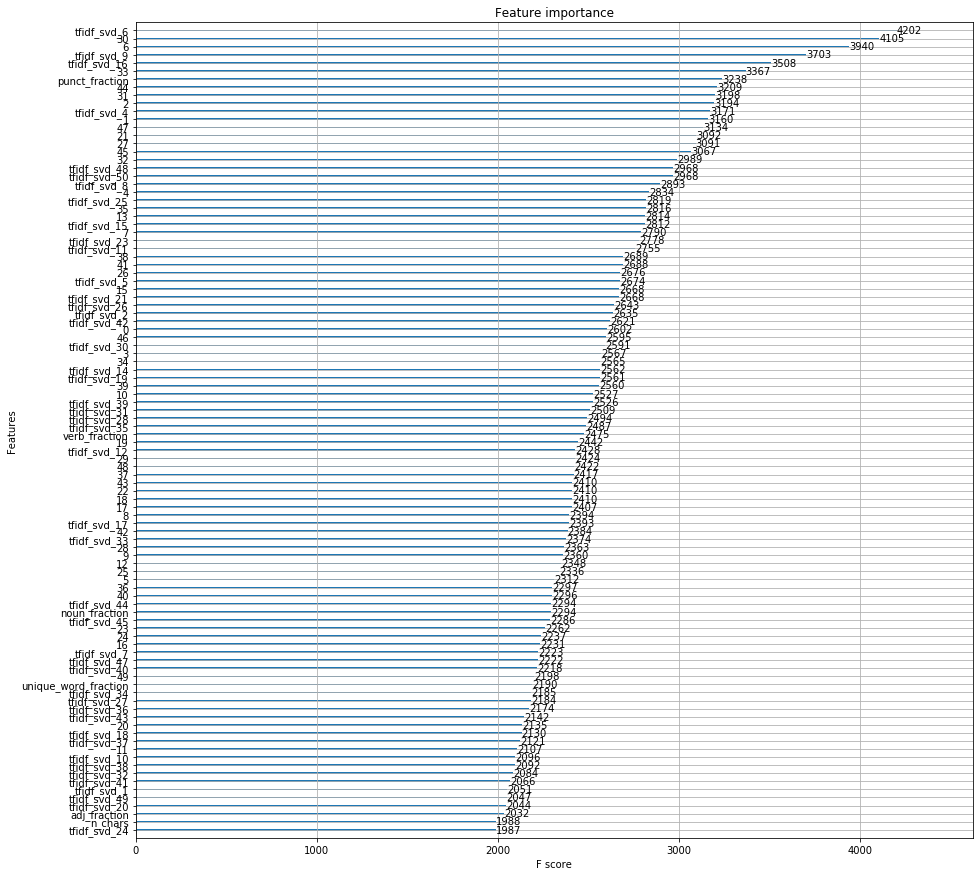

In [117]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model, 
                ax = ax,
                max_num_features=100)
plt.show()